In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statistics import mean 
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [17]:
data = pd.read_csv('newMainData.csv')

In [18]:
# descriptive statistics (min/max/mean/median/sd)
data.describe()

,budget,revenue,profit,success,belongs_to_collection,count_language,runtime,genre_encode,actorAwardNominations,actorAwardWins,actorMovies,directorAwardNominations,directorAwardWins,directorMovies
count,6.955000e+03,6.955000e+03,6.955000e+03,6955.000000,6955.000000,6955.000000,6952.000000,6955.000000,6955.000000,6955.000000,6955.000000,6955.000000,6955.000000,6955.000000
mean,2.961364e+07,8.475309e+07,5.513945e+07,0.658088,0.187203,1.427606,107.744822,5.539756,36.663551,21.586628,72.579439,20.659382,16.154996,25.006183
std,3.951431e+07,1.638829e+08,1.375775e+08,0.474384,0.390103,0.868413,29.116718,4.902644,45.489285,26.915393,49.206904,36.960173,27.875197,28.815188
min,1.000000e+00,0.000000e+00,-1.657101e+08,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,5.000000e+06,4.865456e+06,-2.301927e+06,0.000000,0.000000,1.000000,93.000000,2.000000,4.000000,3.000000,43.000000,2.000000,1.000000,8.000000
50%,1.500000e+07,2.500000e+07,7.780000e+06,1.000000,0.000000,1.000000,104.000000,5.000000,19.000000,11.000000,65.000000,7.000000,5.000000,17.000000
75%,3.750000e+07,8.865338e+07,5.297005e+07,1.000000,0.000000,2.000000,118.000000,6.000000,54.000000,33.000000,91.000000,21.000000,18.000000,32.000000
max,3.800000e+08,2.787965e+09,2.550965e+09,1.000000,1.000000,9.000000,877.000000,20.000000,359.000000,174.000000,651.000000,296.000000,190.000000,634.000000


## Descriptive Statistics

Data definitions:

    Profit: Revenue - Budget
    Success: 1 = Net Gain (Profit positive)
             0 = Net Loss (Profit Negative)
    Belongs to a collection (Movie belongs in a series): 1 = Yes, 0 = No

From looking at the descriptive statistics of our data, about 66% of movies in our sample succeeded. This value correspondes to our intuition, where most movies are popular enough to break even due peoples' tendency to choose electronic entertainment. However, the standard deviation is 0.47, which is about 70% of the sample mean which brings up the question of how reliable this value is for a population. Given the standard deviation, we believe that it is not reliable. 


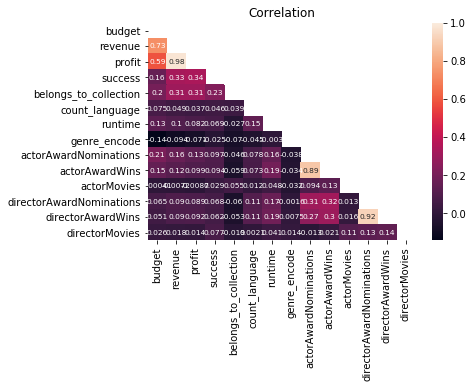

In [19]:
# correlation for ORIGINAL DATA:
corr = data.corr()

ax = plt.axes()
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr, ax=ax, annot=True, mask=dropSelf, annot_kws={"size":7.5})
ax.set_title("Correlation")
plt.show()


## Correlation matrix

From the correlation matrix, it seems like the greatest correlation to revenue comes from budget. We ignore profit in this case because revenue and profit are colinear. It appears that the other variables that have stronger correlations to revenue relative to the other variables are success (which is already somewhat related to revenue) and belongs_to_collection. The correlations for other varialbes very poor, hovering about 0.10 or intensely less than that.

In [20]:
success_counts = data['success'].value_counts()
collection_counts = data['belongs_to_collection'].value_counts()
language_counts = data['count_language'].value_counts()

Text(0.5, 1.0, 'Counts of Movies that Profited')

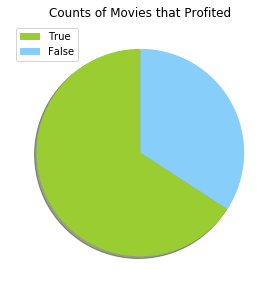

In [21]:
labels = ['True', 'False']
colors = ['yellowgreen', 'lightskyblue']
patches, texts = plt.pie(success_counts, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.tight_layout()
plt.title("Counts of Movies that Profited")

## Pie chart of movies that profited

About 2/3 of movies from our sample profited.

Text(0.5, 1.0, 'Distribution Plot of Movie Runtime')

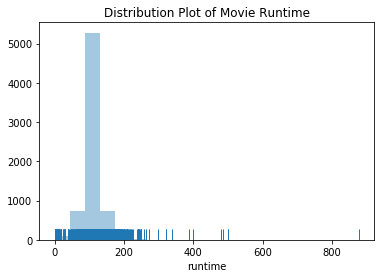

In [22]:
# Distribution Plot of Movie Runtime

sns.distplot(data['runtime'].dropna(), kde=False, 
             bins=20, rug=True).set_title('Distribution Plot of Movie Runtime')

## Distribution of runtime

It seems like the distribution for movie runtimes is somewhat normal but is heavily dense at around the 100-120 minute mark. There are a couple of outliers that should be removed before analysis such as the datapoint around the 800 minute mark.

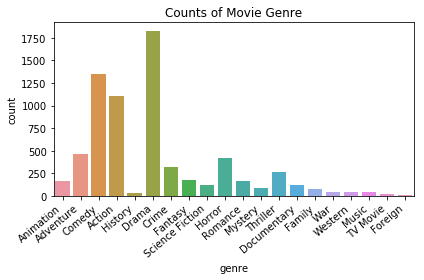

In [23]:
genre_counts = data['genre'].value_counts()

ax = sns.countplot(x=data['genre'], data=genre_counts)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Counts of Movie Genre')
plt.tight_layout()
plt.show()

## Counts of movies by genre

Most movies are either drama, comedy or action, with a fewer number in animation, adventure, horror, and thriller. 

In [24]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

# Splits the data into Training, Test, and Validation groups for analysis

regression_data = data[['budget', 'revenue', 'success','belongs_to_collection', 
                        'count_language', 'runtime', 'genre_encode', 'profit', 'actorAwardNominations',
                        'actorAwardWins', 'actorMovies','directorAwardNominations', 'directorAwardWins',
                        'directorMovies']]
regression_data = regression_data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
y = regression_data[['profit']]
df = regression_data[['budget','belongs_to_collection', 'count_language', 'runtime', 'genre_encode',
                      'actorAwardNominations', 'actorAwardWins', 'actorMovies','directorAwardNominations',
                      'directorAwardWins', 'directorMovies']]


X_train, X_test, y_train, y_test = train_test_split(
        df,
        y,
        test_size=0.2
    )
    # Run train_test_split again to get train and validate sets
post_split_validate_size = 0.1 / (1 - 0.2)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=post_split_validate_size
)

In [26]:
# Lavi's Forward Selection Code

currentRegression = []
available = list(X_train.columns)

bestAllTimeAic = np.inf
flag = True

while flag:
    currentBestAic = np.inf
    print("Current best AIC = " + str(bestAllTimeAic))
    print("Current regression: " + ', '.join(currentRegression))
    toAdd = None
    for each in available:
        regTemp = currentRegression[:]
        regTemp.extend([each])
        currentLm = sm.OLS(y_train, sm.add_constant(X_train[regTemp])).fit()
        currentAic = currentLm.aic
        print("\tChecking " + each + ": AIC = " + str(currentAic))
        if currentAic < currentBestAic:
            toAdd = each
            currentBestAic = currentAic
    if currentBestAic < bestAllTimeAic:
        print("\t\tAdding " + toAdd + " to model. New best AIC = " + str(currentBestAic) + '\n\n')
        currentRegression.append(toAdd)
        available.remove(toAdd)
        bestAllTimeAic = currentBestAic
    else:
        print("\t\tAdding no new variables to model. Ending forward selection.")
        flag = False

Current best AIC = inf
Current regression: 
	Checking budget: AIC = 193835.14056388845
	Checking belongs_to_collection: AIC = 195560.53533833704
	Checking count_language: AIC = 196009.4641087754
	Checking runtime: AIC = 195996.29037122324
	Checking genre_encode: AIC = 195998.14302530824
	Checking actorAwardNominations: AIC = 195925.06223401
	Checking actorAwardWins: AIC = 195966.48128775286
	Checking actorMovies: AIC = 196018.36599384938
	Checking directorAwardNominations: AIC = 195976.67890002916
	Checking directorAwardWins: AIC = 195973.4526262616
	Checking directorMovies: AIC = 196018.06644959544
		Adding budget to model. New best AIC = 193835.14056388845


Current best AIC = 193835.14056388845
Current regression: budget
	Checking belongs_to_collection: AIC = 193574.32718261666
	Checking count_language: AIC = 193836.96644328872
	Checking runtime: AIC = 193836.49236280576
	Checking genre_encode: AIC = 193833.91675226693
	Checking actorAwardNominations: AIC = 193835.73660384258
	Check

Score: 0.31980709422936393


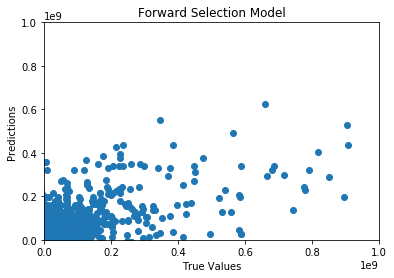

In [27]:
forward_selection_x = X_train[['budget', 'belongs_to_collection']]
forward_selection_y = y_train

lm = linear_model.LinearRegression()

forward_selection_model = lm.fit(forward_selection_x, forward_selection_y)
forward_selection_predictions = forward_selection_model.predict(X_test[['budget', 'belongs_to_collection']])

plt.scatter(y_test, forward_selection_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.ylim(-100000,1000000000)
plt.xlim(-100000,1000000000)
plt.title("Forward Selection Model")


print("Score:", forward_selection_model.score(X_test[['budget', 'belongs_to_collection']], y_test))

## Forward Selection

Using forward selection, we end up with two explanatory variables: Budget and belongs_to_collection. These variables are what we anticipated based on the correlation matrix. The plot displays what the regression model predicted vs the true values of our test set. The data possibly could be better explained with linear regression, but with heavier coefficients we might see a better result. It is also possible that the data can be better explained with a quadratic function.

In [28]:
# Lavi's Backward Selection code

currentRegression = list(X_train.columns)

bestAllTimeAic = np.inf
flag = True

while flag:
    currentBestAic = np.inf
    print("Current best AIC = " + str(bestAllTimeAic))
    print("Current regression: " + ', '.join(currentRegression))
    toDrop = None
    for each in currentRegression:
        regTemp = currentRegression[:]
        regTemp.remove(each)
        currentLm = sm.OLS(y_train, sm.add_constant(X_train[regTemp])).fit()
        currentAic = currentLm.aic
        print("\tChecking " + each + ": AIC = " + str(currentAic))
        if currentAic <= currentBestAic:
            toDrop = each
            currentBestAic = currentAic
    if currentBestAic <= bestAllTimeAic:
        print("\t\tDropping " + toDrop + " from model. New best AIC = " + str(currentBestAic) + '\n\n')
        currentRegression.remove(toDrop)
        bestAllTimeAic = currentBestAic
    else:
        print("\t\tDroping no new variables from model. Ending backward selection.")
        flag = False

Current best AIC = inf
Current regression: budget, belongs_to_collection, count_language, runtime, genre_encode, actorAwardNominations, actorAwardWins, actorMovies, directorAwardNominations, directorAwardWins, directorMovies
	Checking budget: AIC = 195388.82533452057
	Checking belongs_to_collection: AIC = 193809.36291686428
	Checking count_language: AIC = 193527.92099623816
	Checking runtime: AIC = 193526.0154150665
	Checking genre_encode: AIC = 193530.87153676694
	Checking actorAwardNominations: AIC = 193525.28290246835
	Checking actorAwardWins: AIC = 193525.08170640923
	Checking actorMovies: AIC = 193526.31734838415
	Checking directorAwardNominations: AIC = 193526.4340409009
	Checking directorAwardWins: AIC = 193539.26632803414
	Checking directorMovies: AIC = 193525.69645574183
		Dropping actorAwardWins from model. New best AIC = 193525.08170640923


Current best AIC = 193525.08170640923
Current regression: budget, belongs_to_collection, count_language, runtime, genre_encode, actorAw

Score: 0.31980709422936393


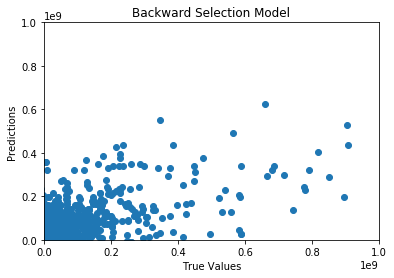

In [30]:
backward_selection_x = X_train[['budget', 'belongs_to_collection']]
backward_selection_y = y_train

lm = linear_model.LinearRegression()

backward_selection_model = lm.fit(backward_selection_x, backward_selection_y)
backward_selection_predictions = backward_selection_model.predict(X_test[['budget', 'belongs_to_collection']])

plt.scatter(y_test, backward_selection_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.ylim(-100000,1000000000)
plt.xlim(-100000,1000000000)
plt.title("Backward Selection Model")


print("Score:", backward_selection_model.score(X_test[['budget', 'belongs_to_collection']], y_test))



## Backwards Selection

After running backwards selection, we are left with the variables: budget, belongs_to_collection, and genre. The plot compared to the forward selection plot is essentially similar as the correlation from genre to revenue is ~0.10. 